In [54]:
!pip install pmdarima

In [55]:
import pmdarima as pm
from pmdarima.arima import ndiffs
import numpy as np
import pandas as pd
import pickle
import boto3
from io import StringIO
from datetime import date, timedelta
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima.metrics import smape

from utils_functions import *

## Functions

In [56]:
def calculate_sarimax_metrics(test, forecasts):
    """Calculate MAE and RMSE metrics for SARIMAX predictions.

    Args:
        test (pd.Series): The actual observed values.
        forecasts (pd.DataFrame): The SARIMAX model predictions, must include a 'predicted_mean' column.

    Returns:
        tuple: Contains the MAE and RMSE values for the SARIMAX model.
    """
    sarimax_mae = mean_absolute_error(test, forecasts.predicted_mean)
    sarimax_mse = mean_squared_error(test, forecasts.predicted_mean)
    sarimax_rmse = np.sqrt(sarimax_mse)

    print(f"SARIMAX MAE: {sarimax_mae:.2f}, SARIMAX RMSE: {sarimax_rmse:.2f}")

def plot_sarimax_forecast(forecasts):
    """Plot SARIMAX forecast with observed values, predictions, and confidence intervals.

    Args:
        forecasts (pd.DataFrame): DataFrame containing the SARIMAX forecast results.
            Should include the following columns: 
            - 'test': Actual observed values (test data).
            - 'predicted_mean': Predicted mean values from the SARIMAX model.
            - 'lower_bound': Lower bound of the forecast confidence interval.
            - 'upper_bound': Upper bound of the forecast confidence interval.

    Returns:
        None: Displays the SARIMAX forecast plot.
    """
    fig = make_subplots()

    fig.add_trace(go.Scatter(
        x=forecasts.index, 
        y=forecasts.number_of_riderships, 
        name='Actual',
        line=dict(dash='solid')
    ))

    fig.add_trace(go.Scatter(
        x=forecasts.index, 
        y=forecasts.predicted_mean, 
        mode='lines+markers',
        name='Mean-SARIMAX Forecast',
        marker=dict(symbol='circle', size=6),
        line=dict(dash='dot')
    ))

    fig.add_trace(go.Scatter(
        x=forecasts.index, 
        y=forecasts.lower_bound, 
        mode='lines+markers',
        name='P25-SARIMAX Forecast',
        marker=dict(symbol='triangle-up', size=8),
        line=dict(dash='dot')
    ))

    fig.add_trace(go.Scatter(
        x=forecasts.index, 
        y=forecasts.upper_bound, 
        mode='lines+markers',
        name='P75-SARIMAX Forecast',
        marker=dict(symbol='triangle-down', size=8),
        line=dict(dash='dot')
    ))

    fig.update_layout(
        title='SARIMAX Forecasting for Next 30 Days',
        xaxis_title='Time',
        yaxis_title='Value',
        legend_title='Series',
        width=800,
        height=500
    )

    fig.show()
    
def forecast_periods(model_name, forecast_steps, alpha=0.4):
    """Generates future period predictions using a forecasting model.

    This function uses a forecasting model to predict future values and 
    compute corresponding confidence intervals. It returns a DataFrame 
    containing the predicted mean, lower bound, and upper bound of 
    the confidence interval.

    Args:
        model_name: A forecasting model object with a `predict` method.
            The model should support a `predict` method with parameters 
            `n_periods` and `return_conf_int`.
        forecast_steps (int): The number of periods to forecast.

    Returns:
        pd.DataFrame: A DataFrame with the following columns:
            - 'predicted_mean': Predicted mean values.
            - 'lower_bound': Lower bound of the confidence interval.
            - 'upper_bound': Upper bound of the confidence interval.

    """
    forecast_obj = model_name.get_forecast(steps=forecast_steps)
    forecast_mean = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int(alpha=alpha)

    predictions = pd.concat([forecast_mean, conf_int], axis=1)
    predictions.columns = ['predicted_mean', 'lower_bound', 'upper_bound']
    return predictions


In [57]:
# Constants
STATION_ID = 611
DATE_CUTOFF = '2024-08-31'

## Import Dataset

In [58]:
file_key = 'data-transformed/run-1731935541465-part-r-00000.csv'
mta_subway_df = read_s3_csv_to_dataframe(file_key)

In [59]:
mta_subway_df.head()

,station_complex_id,station_complex,latitude,longitude,georeference,number_of_riderships,created_date,year_period
0,155,"Cathedral Pkwy (110 St) (C,B)",40.800602,-73.95816,POINT (-73.95816 40.800602),2398.0,2023-01-01,2023
1,231,"Grand St (B,D)",40.718266,-73.99375,POINT (-73.99375 40.718266),11274.0,2023-01-01,2023
2,299,Dyckman St (1),40.860530,-73.92554,POINT (-73.92554 40.86053),1940.0,2023-01-01,2023
3,321,18 St (1),40.741040,-73.99787,POINT (-73.99787 40.74104),1955.0,2023-01-01,2023
4,395,103 St (6),40.790600,-73.94748,POINT (-73.94748 40.7906),2834.0,2023-01-01,2023


## Transform Dataset

In [60]:
mta_subway_df = mta_subway_df.sort_values(by=["created_date"], ascending=True)
mta_subway_df.set_index('created_date', inplace=True)
mta_subway_by_station = mta_subway_df[mta_subway_df['station_complex_id'] == STATION_ID][['number_of_riderships']]

In [61]:
mta_subway_by_station.head()

,number_of_riderships
created_date,
2023-01-01,86058.0
2023-01-02,74470.0
2023-01-03,115731.0
2023-01-04,123241.0
2023-01-05,121052.0


In [62]:
mta_subway_by_station.tail()

,number_of_riderships
created_date,
2024-09-26,131679.0
2024-09-27,115742.0
2024-09-28,66643.0
2024-09-29,55236.0
2024-09-30,60655.0


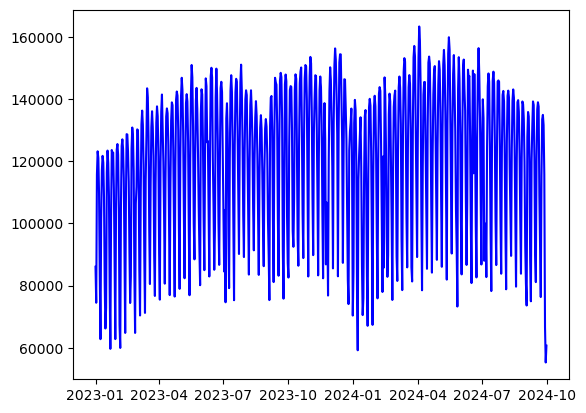

In [63]:
plt.plot(mta_subway_by_station, color='blue', label='Training Data')

## Split Dataset

In [64]:
train_data = mta_subway_by_station.iloc[mta_subway_by_station.index <= '2024-08-31'] 
test_data = mta_subway_by_station.iloc[mta_subway_by_station.index > '2024-08-31'] 

In [65]:
train_data.shape, test_data.shape

((609, 1), (30, 1))

## Train Model

In [66]:
kpss_diffs = ndiffs(train_data, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_data, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


- Usaremos un d = 1

In [67]:
sarimax_model = SARIMAX(train_data, order=(1,n_diffs,1), seasonal_order=(2,0,0,7))
sarimax_fitted = sarimax_model.fit()

forecast_steps = 30
forecasts = pd.concat([test_data, forecast_periods(sarimax_fitted, forecast_steps)], axis=1)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11156D+01    |proj g|=  1.51960D-01

At iterate    5    f=  1.10425D+01    |proj g|=  1.15544D-02


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.



At iterate   10    f=  1.10368D+01    |proj g|=  3.22386D-03

At iterate   15    f=  1.10359D+01    |proj g|=  2.60144D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     20      1     0     0   3.459D-05   1.104D+01
  F =   11.035892409316046     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


## Validation

In [68]:
calculate_sarimax_metrics(test_data, forecasts)

SARIMAX MAE: 10670.95, SARIMAX RMSE: 18001.07


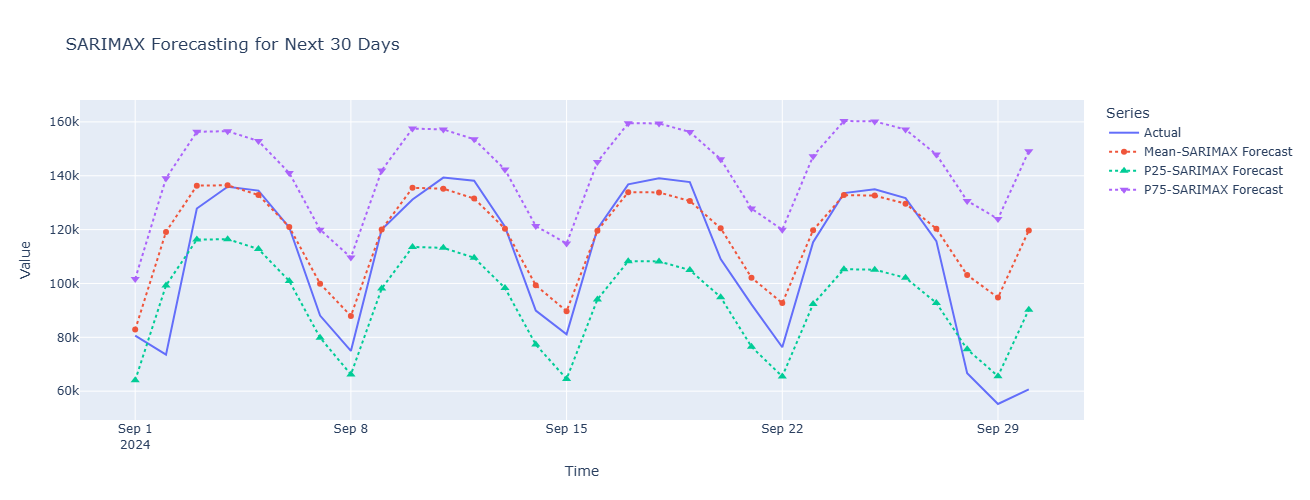

In [69]:
plot_sarimax_forecast(forecasts)

## Update the model with test data

In [70]:
sarimax_fitted_post = sarimax_fitted.append(test_data)

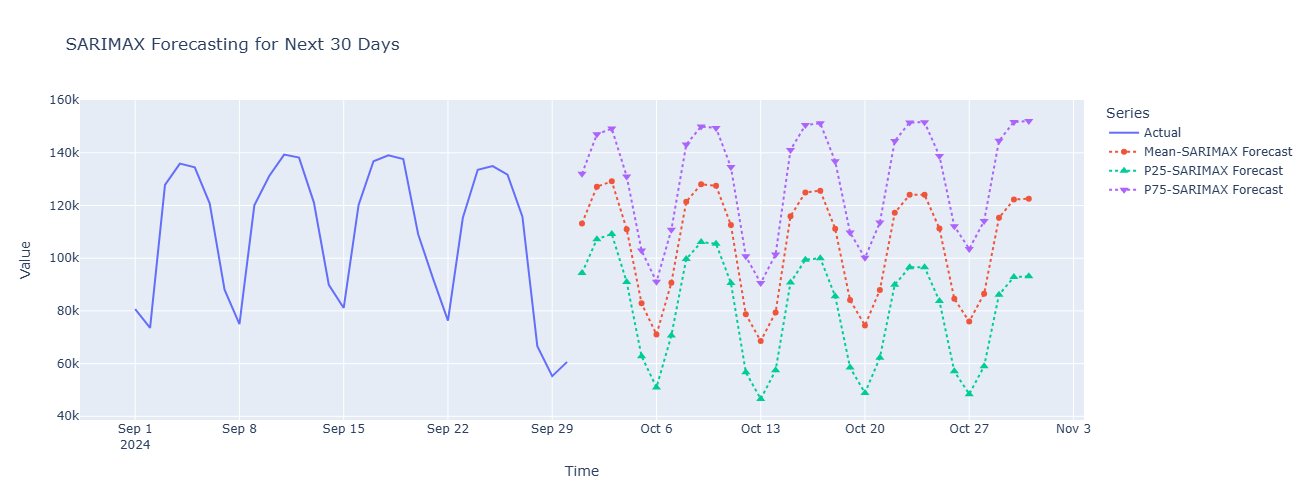

In [71]:
forecast_steps = days_in_next_month()
forecasts_next_month = pd.concat([test_data, forecast_periods(sarimax_fitted_post, forecast_steps)], axis=0)

plot_sarimax_forecast(forecasts_next_month)

## Save Datasets

In [19]:
#Guardar el DataFrame en S3
save_dataframe_to_s3(train_data, bucket_name, 'data-splitted/train_data.csv')
save_dataframe_to_s3(test_data, bucket_name, 'data-splitted/test_data.csv')

DataFrame successfully saved to s3://mta-subway/data-splitted/train_data.csv
DataFrame successfully saved to s3://mta-subway/data-splitted/test_data.csv


## Save Model

In [20]:
with open('sarimax_model.pkl', 'wb') as f:
    pickle.dump(sarimax_fitted_post, f)